The Multi-Armed Bandit (MAB) is a problem where an agent chooses among several options (arms), each with an unknown reward distribution, with the goal of maximizing cumulative reward over time. There are several ways to solve this problem, including Epsilon Greedy and Upper Confidence Bound (UCB). Let’s go through both:

In [1]:
import numpy as np

# Defining the distributions
class Arms:
    def __init__(self, type, param1, param2):
        self.type = type
        self.param1 = param1
        self.param2 = param2

    def get_reward(self):
        if self.type == 'uniform':
            return np.random.uniform(self.param1, self.param2)
        if self.type == 'gaussian':
            return np.random.normal(self.param1, self.param2)
        if self.type == 'exponential':
            return np.random.exponential(1.0 / self.param1)
        if self.type == 'beta':
            return np.random.beta(self.param1, self.param2)


In [2]:
arm1 = Arms('uniform', 5, 10)
arm2 = Arms('gaussian', 6, 2)
arm3 = Arms('exponential', 1/4, 0)
arm4 = Arms('beta', 2, 5)
arm5 = Arms('uniform', -5, 0)
arm6 = Arms('gaussian', 10, 6)
arm7 = Arms('exponential', 1/7, 0)
arm8 = Arms('beta', 5, 2) 

arms = [arm1, arm2, arm3, arm4, arm5, arm6, arm7, arm8]

In epsilon greedy, we define a number epsilon which dictates how often we explore and exploit.  
Eploration consists of choosing a random arm and getting more information whilst exploiting is choosing the arm that you know gives the maximum rewards (based on the information you have so far).

In [3]:
class EpsilonGreedy:
    def __init__(self, arms, steps, epsilon):
        self.arms = arms
        self.epsilon = epsilon
        self.steps = steps
        # TODO: Initialize parameters
        self.estimated_rewards = [0.0] * len(arms) # Estimated rewards of all arms
        self.action_count = [0] * len(arms) # Number of times arm 'i' is chosen (for all arms)
        self.total_reward = 0
        self.rewards = []

    def select_action(self):
        # TODO: Implement epsilon greedy approach of choosing arms here
        # Return action chosen (which arm to pick)
        if np.random.random() < self.epsilon :
            action = np.random.randint(0,len(self.arms))
        else :
            action = np.argmax(self.estimated_rewards)
        return action

    def update(self, action, reward):
        # TODO: Update estimated_rewards, action_count, total_reward, and rewards array here
        self.action_count[action] += 1
        n = self.action_count[action]
        old_estimate = self.estimated_rewards[action]
        new_estimate = old_estimate + (1 / n) * (reward - old_estimate)
        self.estimated_rewards[action] = new_estimate

        self.total_reward += reward
        self.rewards.append(reward)

    def run(self):
        for _ in range(self.steps):
            action = self.select_action()
            reward = self.arms[action].get_reward()
            self.update(action, reward)

        return self.total_reward, self.estimated_rewards, self.rewards

Total reward: 9136.282479463885
Estimated means: [7.819365971698882, 5.680885818229494, 2.5583689517402584, 0.2808986216558306, -2.680211793174735, 9.49451100892947, 7.0485328950591395, 0.8373445011308855]


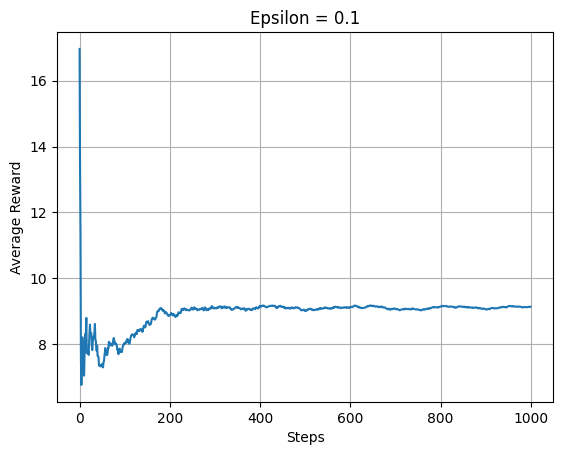

In [4]:
steps = 1000
epsilon = 0.1 # Play around with this value

banditEG = EpsilonGreedy(arms, steps, epsilon)
total_reward, estimated_reward, rewards = banditEG.run()
print(f"Total reward: {total_reward}")
print(f"Estimated means: {estimated_reward}")

# TODO: Plot average rewards over time (use np.cumsum)

average_rewards = np.cumsum(rewards) / (np.arange(steps) + 1)

import matplotlib.pyplot as plt
plt.plot(average_rewards)
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.title(f"Epsilon = {epsilon}")
plt.grid(True)
plt.show()

In upper confidence bound, we have the upper confidence estimate where we use both the estimated mean and the number of times we have picked that option. The more times you have chosen something, the more certain you are of its estimated mean. Using this we have 2 terms, the estimated mean and the confidence score. The constant c dictates how much the confidence score affects our choice.

$UCB_t(a) = \hat{Q}_t(a) + c \cdot \sqrt{\frac{\ln t}{N_t(a)}}$  
$\hat{Q}_t(a)$ is the estimated reward. $N_t(a)$ is the number of times arm $a$ has been picked and $t$ is the timestamp

In [ ]:
class UpperConfidenceBound:
    def __init__(self, arms, steps, c):
        self.arms = arms
        self.steps = steps
        self.c = c
        # TODO: Initialize parameters
        self.estimated_rewards =  np.zeros(len(arms))# Estimated rewards of all arms
        self.action_count = np.zeros(len(arms)) # Number of times arm 'i' is chosen (for all arms)
        self.total_reward = 0
        self.rewards = []
        self.t = 0

    def select_action(self, t):
        if t < len(self.arms):
            return t  

        ucb_values = np.zeros(len(self.arms))
        for i in range(len(self.arms)):
            bonus = self.c * np.sqrt(np.log(t) / (self.action_count[i] + 1e-5))
            ucb_values[i] = self.estimated_rewards[i] + bonus

        return np.argmax(ucb_values)

    def update(self, action, reward):
        self.action_count[action] += 1
        n = self.action_count[action]
        old_estimate = self.estimated_rewards[action]
        self.estimated_rewards[action] += (reward - old_estimate) / n

        self.total_reward += reward
        self.rewards.append(self.total_reward / sum(self.action_count)) 

    def run(self):
        for t in range(self.steps):
            action = self.select_action(t)
            reward = self.arms[action].get_reward()
            self.update(action, reward)

        return self.total_reward, self.estimated_rewards, self.rewards

Total reward: 9341.15816507826
Estimated means: [ 7.64117619  4.96949616  3.15831713  0.37322285 -3.08792103  9.99804394
  0.66524417  0.78101853]


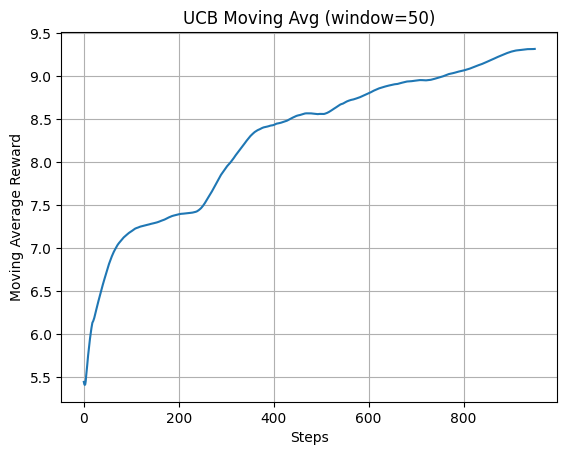

In [7]:
steps = 1000
c = 2 # Play around with this value

banditUCB = UpperConfidenceBound(arms, steps, c)
total_reward, estimated_reward, rewards = banditUCB.run()
print(f"Total reward: {total_reward}")
print(f"Estimated means: {estimated_reward}")

# TODO: Plot average rewards over time (use np.cumsum)
window = 50
moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
plt.plot(moving_avg)
plt.xlabel("Steps")
plt.ylabel("Moving Average Reward")
plt.title(f"UCB Moving Avg (window={window})")
plt.grid(True)
plt.show()

## Optional challenges

1. if you already know the distribution the arms draw from(eg: gaussian), can you incorporate that knowledge to learn faster

We will host a competition where we will run your agents and host a leaderboard(details in the next meet)